In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

oName='datasets/Robot1_Odometry.dat'
mName='datasets/Robot1_Measurement.dat'
gName='datasets/Robot1_Groundtruth.dat'


def readData(oName,mName,gName):
    namesOdom="Time[s]    forward_velocity[m/s]    angular_velocity[rad/s]".split()
    odom=pd.read_csv(oName,sep=r"\s*",skiprows=4,names=namesOdom,engine='python')

    namesMeas="Time[s]    Subject_#    range[m]    bearing[rad]".split()
    meas=pd.read_csv(mName,sep=r"\s*",skiprows=4,names=namesMeas,engine='python')

    namesGroun="Time[s]    x[m]    y[m]    orientation[rad]".split()
    groun=pd.read_csv(gName,sep=r"\s*",skiprows=4,names=namesGroun,engine='python')
    
    odom=np.array(odom.values)
    meas=np.array(meas.values)
    groun=np.array(groun.values)
    
    return odom,meas,groun

moeName='betw.meas'
    

# print(odom.head(),len(odom))


In [2]:
def makeMoeO(meas,odom):    
    #meas=groun
    #moeName='betw.groun' 
    
    print(meas.iloc[0,0])
    i=0
    j=0
    N=len(odom)
    M=len(meas)
    eden=[-1]
    dva=[]
    ednak=0
    state=0
    while i<N and j<M:
        #if i%8000==2: print (i,flush=True)

        if meas.iloc[j,0]>odom.iloc[i,0]:
            eden[-1]+=1
            state=0
            i+=1
        elif meas.iloc[j,0]<=odom.iloc[i,0]:
            j+=1
            state=0
            if j<M and  meas.iloc[j,0]<odom.iloc[i,0]:
                eden.append(i-1)
            elif j<M and  meas.iloc[j,0]==odom.iloc[i,0]:
                eden.append(i)
            elif j<M:
                eden.append(i-1)

        # elif state==0 and meas.iloc[j,0]==odom.iloc[i,0]:
        # 	i+=1
        # 	state=1
        # elif state==1 and  meas.iloc[j,0]==odom.iloc[i,0]:
        # 	j+=1
    moe=np.zeros(M,dtype=float)
    moe[0]=eden[0]
    for i,x in enumerate(eden[1:]):
        moe[i+1]=(eden[i+1]-eden[i])
    return moe


In [3]:
def makeMoe(meas,odom,toP=False):    

    print(len(odom),len(set(odom[:,0])),flush=True)
    if len(odom)!=len(set(odom[:,0])):
        dikO={}
        for i in odom:
            dikO[i[0]]=dikO.get(i[0],0)+1
        print([(i,dikO[i]) for i in dikO if dikO[i]!=1][0])
        print('odom duplicates!')
        #sys.exit(-28)
    i=0
    j=0
    br=0
    eden=[]
    N=len(odom)
    M=len(meas)
    while i<N and j<M:
        if i%18000==2 and toP==True: print (i,flush=True)

        if meas[j,0]>=odom[i,0] and i+1<N and meas[j,0]>=odom[i+1,0]:
            i+=1
            br+=1
        elif meas[j,0]>=odom[i,0]:
            br+=1
            eden.append(br)
            br=0
            j+=1
            i+=1
        elif meas[j,0]<odom[i,0]:
            j+=1
            if br!=0: print('br different 0',i,j)
            eden.append(br)
    sumDif=len(odom)-sum(eden)
    print("sum diff",sumDif)
    eden.append(sumDif)
    return eden

In [6]:
def testAlEmpty(mo,ind,mSub,mTime,allowSub):
    if mo>0:
        return True
    res=0
    for sub in mSub[np.where(mTime==mTime[ind])[0] ]:
        if sub in allowSub:
              res+=1
    if res==1:
        return True
    return False
def makeComp(measV,moe):
    mSub=np.array([row[1] for row in measV])
    mTime=np.array([row[0] for row in measV])
    dik={}
    for r in mSub:
        dik[r]=dik.get(r,0)+1
    tDif=[b-a for a,b in zip(mTime,mTime[1:])]

#     plt.figure(figsize=(20,10))
#     plt.plot(list(dik.values()))
#     plt.plot(tDif)

    allow=[72, 27, 54, 70, 36, 18, 25, 9, 81, 16, 90, 61, 45, 7, 63]

    allowSub=[True if m in allow else False for ind,m in enumerate(mSub)]
    moeV=[mo for ind,(al,mo) in enumerate(zip(allowSub,moe)) if al==True and testAlEmpty(mo,ind,mSub,mTime,allow)  ]
    moeI=[ind for ind,(al,mo) in enumerate(zip(allowSub,moe)) if al==True and testAlEmpty(mo,ind,mSub,mTime,allow)   ]
    
    moeB=[True if al in allow and  testAlEmpty(mo,ind,mSub,mTime,allow) else False for ind,(al,mo) in enumerate(zip(mSub,moe))]
    print(moeB[:10])
    adjMoe=[]
    br=0
    for tr,mo in zip(moeB,moe):
        br+=mo
        if tr==True:
            adjMoe.append(br)
            br=0
        else:
            adjMoe.append(0)
    adjMoe.append(br)
    return mTime,moeV,moeI,adjMoe




In [54]:
for dataset_i in range(4,5):
    for robot_i in range(3,4):
        oName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Odometry.dat'
        mName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Measurement.dat'
        gName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Groundtruth.dat'

        moeGName="betws/data_{}_betw_{}.groun".format(dataset_i,robot_i)
        moeMName='betws/data_{}_betw_{}.meas'.format(dataset_i,robot_i)

        odom,meas,groun=readData(oName.format(dataset_i,robot_i),mName.format(dataset_i,robot_i),gName.format(dataset_i,robot_i))

        moeM=makeMoe(meas,odom)
        mTime,moeV,moeI,adjMoe=makeComp(meas,moeM[:-1])
        print(adjMoe[:20],len(meas),sum(adjMoe),len(moeM[:-1]))
        print('zeros ',np.sum(np.array(adjMoe)==0))
        sys.exit()

95819 95811
(1248297772.2079999, 2)
odom duplicates!
sum diff 6
[True, True, True, True, True, True, False, True, False, True]
[383, 8, 9, 8, 9, 10, 0, 7, 0, 9, 10, 0, 16, 0, 9, 8, 8, 0, 10, 0] 7720 95813 7720
zeros  3256


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [2]:
i=1
oName='datasets/Robot{}_Odometry.dat'
mName='datasets/Robot{}_Measurement.dat'
gName='datasets/Robot{}_Groundtruth.dat'


odom,meas,groun=readData(oName.format(i),mName.format(i),gName.format(i))

#moe=makeMoe(meas,odom)
moe2=makeMoe(groun,odom)
print(moe2[-20:],len(moe2),len(groun))
#print(sum(moe==moe2),len(moe))

NameError: name 'readData' is not defined

In [65]:
oName='datasets/Robot{}_Odometry.dat'
mName='datasets/Robot{}_Measurement.dat'
gName='datasets/Robot{}_Groundtruth.dat'

for i in range(1,6):
    odom,meas,groun=readData(oName.format(i),mName.format(i),gName.format(i))
    moe=makeMoe(meas,odom)[:-1]
    mTime,moeV,moeI=makeComp(meas,moe)
    
    print("debug {}/{}".format(len(moe),len(meas)))
    print("average total={} , average landmarks={}".format(np.average(moe),np.average(moeV)))
    print("std total={} , std landmarks={}".format(np.std(moe),np.std(moeV)))
    #print(moeI[:3],mTime[moeI][:3][2])
    tDif=[b-a for a,b in zip(mTime,mTime[1:])]
    print('Total Time Dif: avg={} std={}'.format(np.average(tDif),np.std(tDif)))
    
    tDif=[b-a for a,b in zip(mTime[moeI],mTime[moeI][1:])]
    print('Land Time Dif: avg={} std={}'.format(np.average(tDif),np.std(tDif)))
    print('len total={} len landmarks={}'.format(len(moe),len(moeI)))
    print("\n\n==============================\n")

97890 97890
sum diff 10
debug 5723/5723
average total=17.10291804997379 , average landmarks=27.58806068601583
std total=77.59957881591612 , std landmarks=97.74718765194419
Total Time Dif: avg=0.25989252010120123 std=1.148021866624275
Land Time Dif: avg=0.49063180469121526 std=1.6799153770967825
len total=5723 len landmarks=3032



94826 94817
(1248273520.3099999, 2)
odom duplicates!
sum diff 103
debug 6699/6699
average total=14.139871622630244 , average landmarks=22.73401323042999
std total=45.981677491350666 , std landmarks=60.42998336427589
Total Time Dif: avg=0.22189728278977083 std=0.6789404476949908
Land Time Dif: avg=0.40977888065229806 std=0.9635753439632748
len total=6699 len landmarks=3628



97351 97329
(1248272617.329, 2)
odom duplicates!
sum diff 8
debug 8742/8742
average total=11.135094943948753 , average landmarks=20.220347394540944
std total=45.6548271380544 , std landmarks=64.8052442726599
Total Time Dif: avg=0.16999027571107003 std=0.6461308222996245
Land Time Dif: avg

92443 92424
(1248298318.8169999, 2)
odom duplicates!
sum diff 1
92443 92443 92443 5535 5536 5536 


92443 92424
(1248298318.8169999, 2)
odom duplicates!
sum diff 0


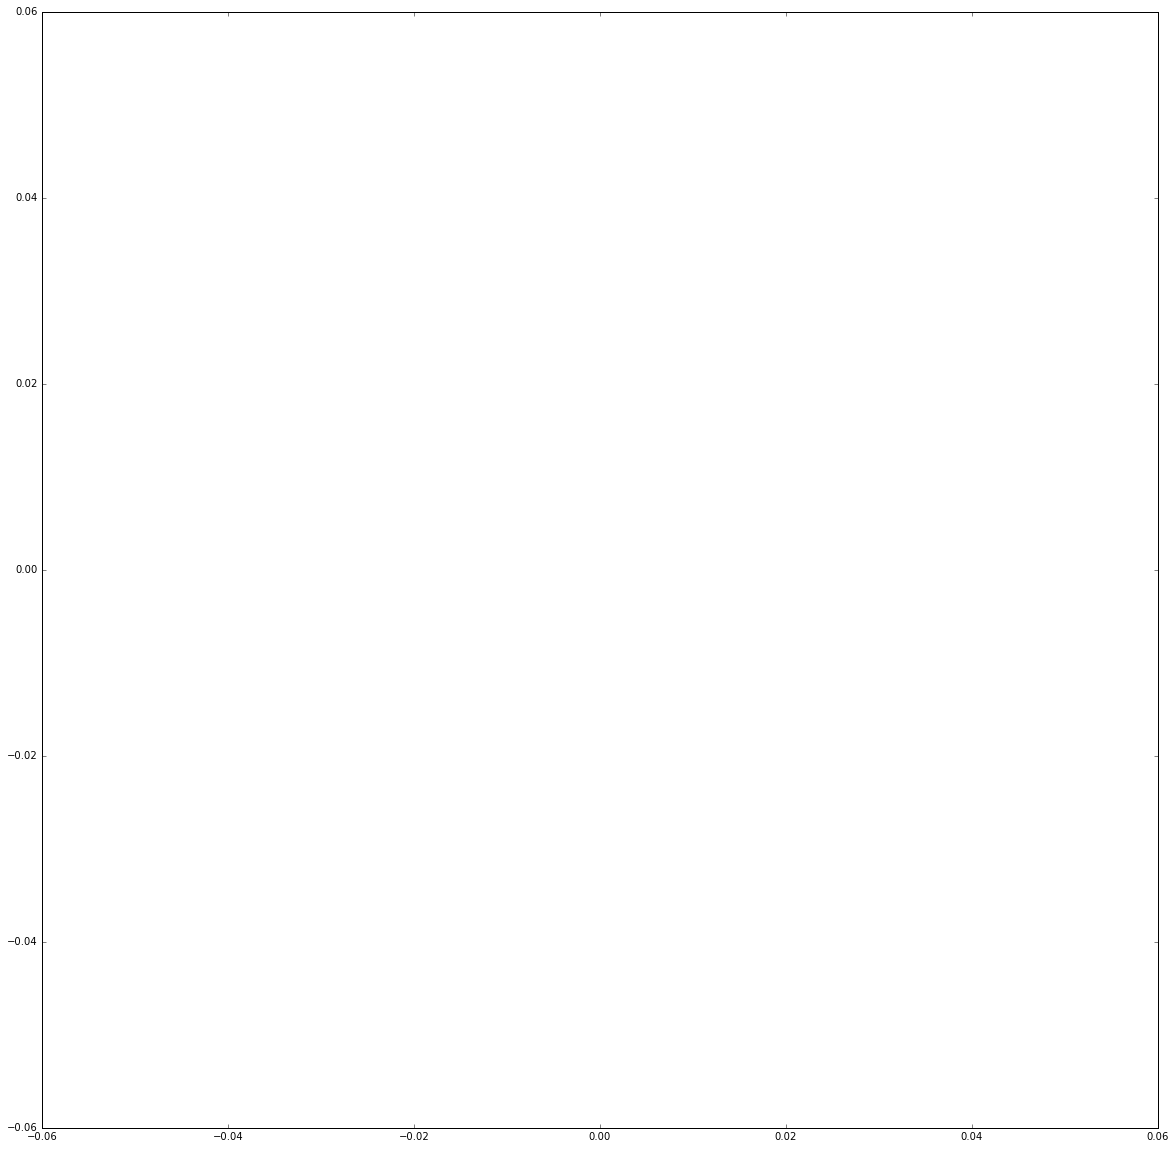

In [8]:

i=4
oName='datasets/Robot{}_Odometry.dat'
mName='datasets/Robot{}_Measurement.dat'
gName='datasets/Robot{}_Groundtruth.dat'

moeGName="betw_{}.groun".format(i)
moeMName='betw_{}.meas'.format(i)

odom,meas,groun=readData(oName.format(i),mName.format(i),gName.format(i))

moeM=makeMoe(meas,odom)
mTime,moeV,moeI,adjMoe=makeComp(meas,moeM[:-1])
adjMoe[-1]+=moeM[-1]
adjMoe=np.array(adjMoe)

plt.figure(figsize=(20,20))
plt.plot(adjMoe[7135:])
#plt.plot(moeM)

print(sum(adjMoe),sum(moeM),len(odom),len(meas),len(adjMoe),len(moeM),'\n\n===================\n')

moeG=makeMoe(groun,odom)

with open(moeMName,'wb') as f:
    pickle.dump((moeM,adjMoe),f)
with open(moeGName,'wb') as f:
    pickle.dump(moeG,f)

In [17]:
#moe=makeMoe(meas,odom)
mTime,moeV,moeI=makeComp(meas,moe)
print (sum(moe[moeI]==moeV),len(moeV))

4335 4335


1


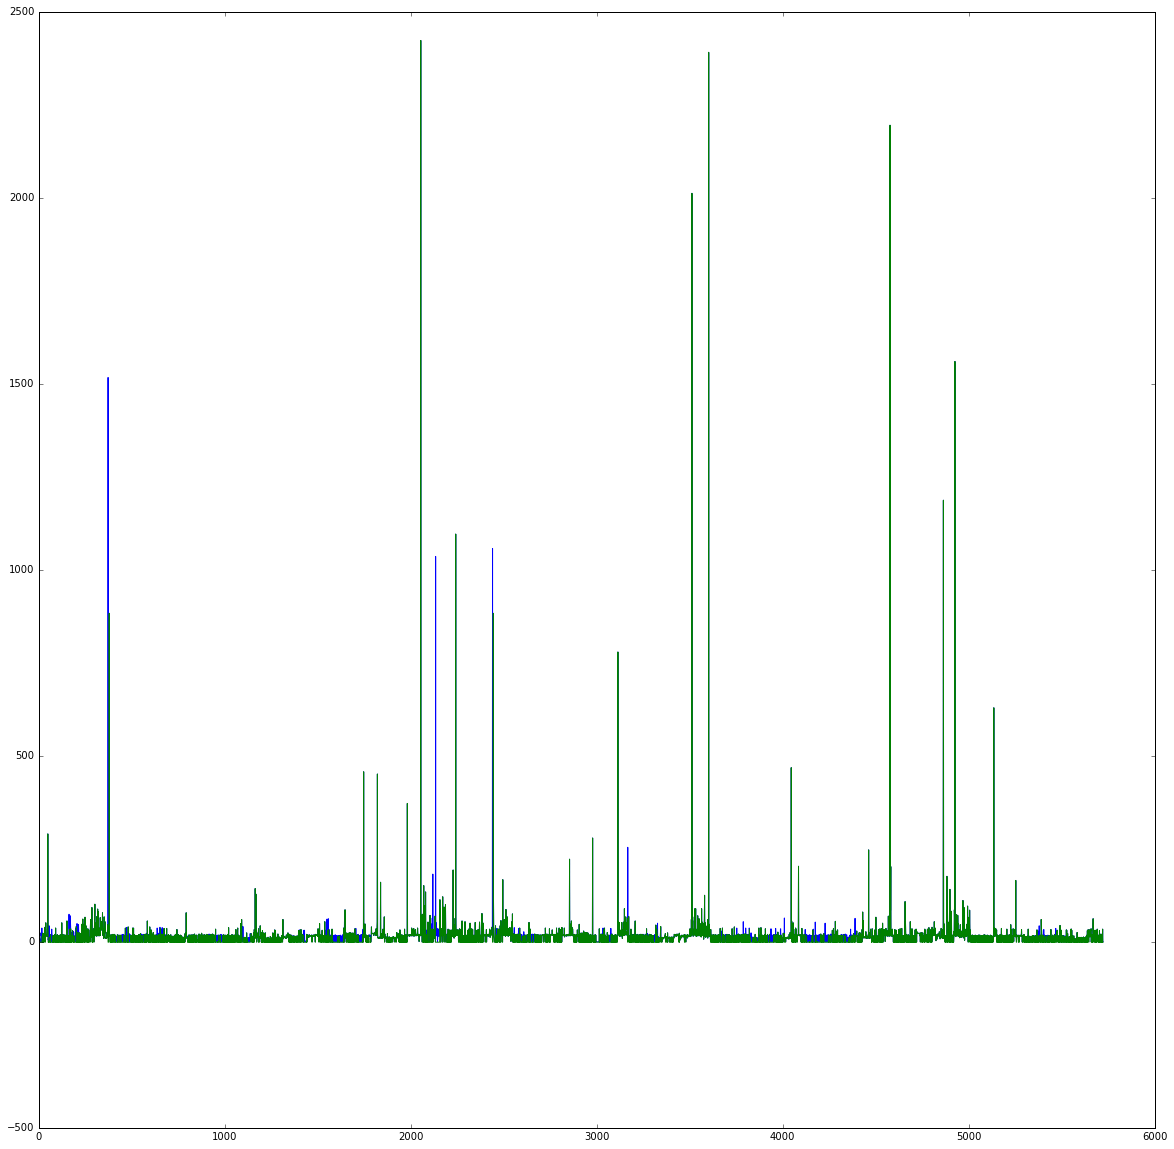

In [45]:
plt.figure(figsize=(20,20))
#plt.hist(moe[moe>0],bins=500)
plt.plot(moe)
plt.plot(moeV)
print(1)

In [7]:
"This saves for each dataset in a separate folder"

for dataset_i in range(1,10):
    for robot_i in range(1,6):
        oName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Odometry.dat'
        mName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Measurement.dat'
        gName='datasets/all_data/MRCLAM_Dataset{}/Robot{}_Groundtruth.dat'

        moeGName="betws_lessS/data_{}_betw_{}.groun".format(dataset_i,robot_i)
        moeMName='betws_lessS/data_{}_betw_{}.meas'.format(dataset_i,robot_i)

        odom,meas,groun=readData(oName.format(dataset_i,robot_i),mName.format(dataset_i,robot_i),gName.format(dataset_i,robot_i))

        moeM=makeMoe(meas,odom)
        mTime,moeV,moeI,adjMoe=makeComp(meas,moeM[:-1])
        adjMoe[-1]+=moeM[-1]
        adjMoe=np.array(adjMoe)

        #plt.figure(figsize=(20,20))
        #plt.plot(adjMoe[7135:])
        #plt.plot(moeM)

        print(sum(adjMoe),sum(moeM),len(odom),len(meas),len(adjMoe),len(moeM),'\n\n===================\n')

        moeG=makeMoe(groun,odom)

        with open(moeMName,'wb') as f:
            pickle.dump((moeM,adjMoe),f)
        with open(moeGName,'wb') as f:
            pickle.dump(moeG,f)

97890 97890
sum diff 10
[True, False, False, True, False, True, False, False, False, False]
97890 97890 97890 5723 5724 5724 


97890 97890
sum diff 1
94826 94817
(1248273520.3099999, 2)
odom duplicates!
sum diff 103
[True, False, True, False, True, True, True, False, False, True]
94826 94826 94826 6699 6700 6700 


94826 94817
(1248273520.3099999, 2)
odom duplicates!
sum diff 1
97351 97329
(1248272617.329, 2)
odom duplicates!
sum diff 8
[True, False, True, False, False, False, False, False, False, False]
97351 97351 97351 8742 8743 8743 


97351 97329
(1248272617.329, 2)
odom duplicates!
sum diff 0
100012 99993
(1248272818.049, 2)
odom duplicates!
sum diff 10
[True, False, True, True, True, True, False, False, True, False]
100012 100012 100012 3991 3992 3992 


100012 99993
(1248272818.049, 2)
odom duplicates!
sum diff 1
100726 100710
(1248272545.2389998, 2)
odom duplicates!
sum diff 13
[True, True, True, True, True, True, True, True, True, True]
100726 100726 100726 8792 8793 8793 



In [1]:
print('test')

test
